In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from models import *
import random

# Evaluation on the Test Set

In [2]:
# Path to annotation CSV files
test_csv_path = "./test_annotations_E1.csv"

# Folder containing .npy files
data_folder = "./mixed_signals_E1"

# Read the CSV files into pandas DataFrames
test_df = pd.read_csv(test_csv_path)

# Initialize lists to store data and labels
test_data = []
test_labels = []

# Read .npy files and their corresponding SNRs
for _, row in test_df.iterrows():
    file_name = row['mixed_name']
    snr = np.array([row['snr']])
    npy_file_path = os.path.join(data_folder, file_name)
    data = np.load(npy_file_path)
    data = data.reshape(1, 10000)
    test_data.append(data)
    test_labels.append(snr)

# Convert lists to NumPy arrays
test_data = np.array(test_data)
test_labels = np.array(test_labels)

# Print the shapes of the loaded data
print("Test data shape:", test_data.shape)

Test data shape: (43648, 1, 10000)


In [3]:
device = 'cuda:7'
test_data = torch.Tensor(test_data).to(device)
test_labels = torch.Tensor(test_labels).to(device)
test_dataset = TensorDataset(test_data, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [4]:
model = CNNBLSTMATTN()
model = model.to(device)

print(model)
print("Number of trainable parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))

model.load_state_dict(torch.load('./checkpoints/cnnblstmattn_30eps_seed2023.pth'))

CNNBLSTMATTN(
  (conv1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(16,), stride=(8,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv1d(16, 32, kernel_size=(8,), stride=(4,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (lstm): LSTM(32, 64, batch_first=True, bidirectional=True)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)
Number of trainable parameters:  129041


<All keys matched successfully>

In [5]:
# Set model to evaluation mode
model.eval()

# Initialize lists to store predictions and labels
test_predictions = []
test_labels = []

# Iterate through test data
with torch.no_grad():
    for batch_data, batch_labels in test_dataloader:
        predictions = model(batch_data)
        test_predictions.append(predictions.cpu())
        test_labels.append(batch_labels.cpu().numpy())

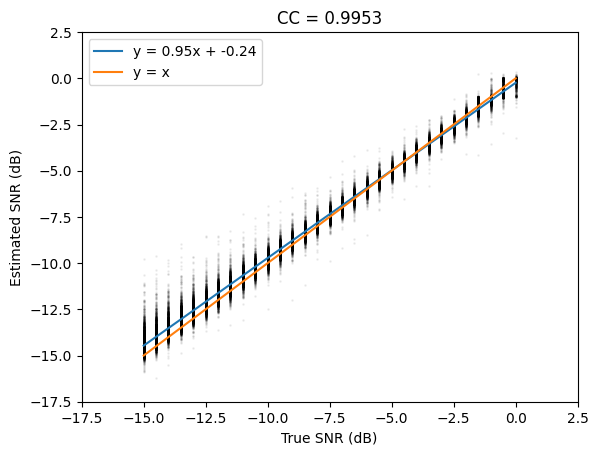

Correlation coefficient (CC): 0.9953
Spearman's rank correlation coefficient (SRCC): 0.9954
Mean Squared Error (MSE): 0.2473
Mean Absolute Error (MAE): 0.3298


In [6]:
# Concatenate predictions and labels
test_predictions_np = np.concatenate(test_predictions, axis=0)
test_labels_np = np.concatenate(test_labels, axis=0)

# Reshape predictions and labels
test_predictions_flat = test_predictions_np.reshape(-1)
test_labels_flat = test_labels_np.reshape(-1)

# Save results
np.save(f'./test_results/y_pred_{model.__class__.__name__.lower()}.npy', test_predictions_flat)
np.save(f'./test_results/y_true_{model.__class__.__name__.lower()}.npy', test_labels_flat)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(test_labels_flat, test_predictions_flat)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test_labels_flat, test_predictions_flat)

# Calculate correlation coefficients
correlation_matrix = np.corrcoef(test_labels_flat, test_predictions_flat)
correlation_coefficient = correlation_matrix[0, 1]
spearmanr_cc, _ = stats.spearmanr(test_labels_flat, test_predictions_flat)

# Plot predictions against true labels
plt.scatter(test_labels_flat, test_predictions_flat, alpha=0.05, s=1, color='black')
plt.xlabel('True SNR (dB)')
plt.ylabel('Estimated SNR (dB)')
plt.title(f'CC = {correlation_coefficient:.4f}')

# Set x-axis and y-axis limits
plt.xlim(-17.5, 2.5)
plt.ylim(-17.5, 2.5)

# Perform linear regression
m, b = np.polyfit(test_labels_flat, test_predictions_flat, 1)
plt.plot(test_labels_flat, m * test_labels_flat + b, label=f"y = {m:.2f}x + {b:.2f}")
plt.plot(test_labels_flat, test_labels_flat, label="y = x")
plt.legend(loc='upper left')
plt.show()

# Print the results
print(f'Correlation coefficient (CC): {correlation_coefficient:.4f}')
print(f"Spearman's rank correlation coefficient (SRCC): {spearmanr_cc:.4f}")
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')

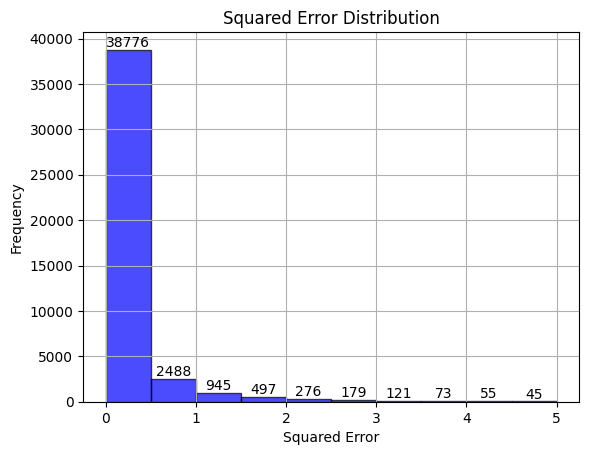

Mean Error: 0.24734128
Standard Deviation of Error: 0.7573675


In [7]:
# Calculate the square error for each element
error = (test_labels_flat - test_predictions_flat)**2

# Calculate mean and standard deviation of the error
mean_error = np.mean(error)
std_deviation_error = np.std(error)

# Plot the error distribution as a histogram
hist, bins, _ = plt.hist(error, bins=10, alpha=0.7, color='blue', edgecolor='black', range=(0, 5))
plt.xlabel('Squared Error')
plt.ylabel('Frequency')
plt.title('Squared Error Distribution')
plt.grid(True)

# Annotate each bar with the frequency
for i in range(len(hist)):
    plt.text(bins[i] + (bins[i+1] - bins[i]) / 2, hist[i], f'{int(hist[i])}', ha='center', va='bottom')

plt.show()

print("Mean Error:", mean_error)
print("Standard Deviation of Error:", std_deviation_error)

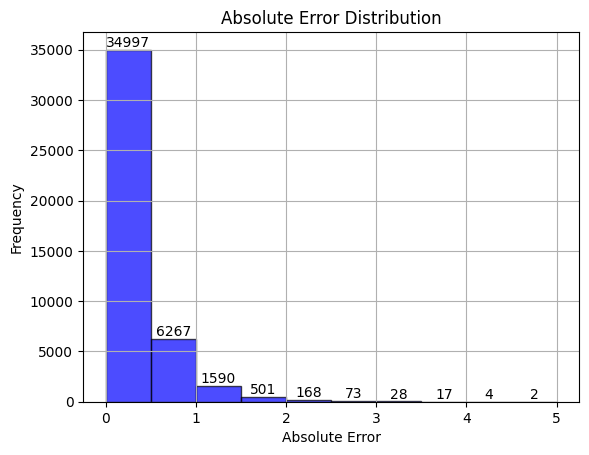

Mean Absolute Error (MAE): 0.32981586
Standard Deviation of Absolute Error: 0.37224025


In [8]:
# Calculate the absolute error for each element
error = np.abs(test_labels_flat - test_predictions_flat)

# Calculate mean and standard deviation of the error
mean_error = np.mean(error)
std_deviation_error = np.std(error)

# Plot the error distribution as a histogram
hist, bins, _ = plt.hist(error, bins=10, alpha=0.7, color='blue', edgecolor='black', range=(0, 5))
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')
plt.title('Absolute Error Distribution')
plt.grid(True)

# Annotate each bar with the frequency
for i in range(len(hist)):
    plt.text(bins[i] + (bins[i+1] - bins[i]) / 2, hist[i], f'{int(hist[i])}', ha='center', va='bottom')

plt.show()

print("Mean Absolute Error (MAE):", mean_error)
print("Standard Deviation of Absolute Error:", std_deviation_error)